In [12]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

def query2df(conn, query):
    return pd.read_sql_query(query,conn)

def parse_loc(loc_str):
    l = json.loads(loc_str)
    loc_type = l["$type"].replace("edu.colorado.plv.bounder.ir.","")
    if loc_type == "AppLoc":
        return [loc_type]
    if loc_type.startswith("InternalMethod"):
        return [loc_type,l["clazz"],l["name"]]
    if loc_type.startswith("CallbackMethod"):
        return [loc_type,l["fmwClazz"],l["fmwName"]]
    

def get_method(conn,class_like,method_like):
    d = pd.read_sql_query(con = conn, 
                         sql = "SELECT * from Methods where DECLARING_CLASS like ? and NAME like ? order by DECLARING_CLASS;",
                         params = [class_like, method_like])
    return d

def get_call_edges(conn,class_name,method_name):
    d = pd.read_sql_query(con = conn,
                         sql = "select TGT_NAME,TGT_CLASS from CALL_EDGES where SRC_NAME=? and SRC_CLASS=?",
                         params = [method_name,class_name])
    return d
def find_mega_call_edge(conn,class_name,method_name):
    edges = get_call_edges(conn,class_name,method_name)
    #TODO
def display_call_edges(conn,class_name,method_name):
    edges = get_call_edges(conn,class_name,method_name)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display(edges)

def display_no_limit(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display(v)
def highlight_text(in_str, replace_strs):
#     colored = "\x1b[31m %s \x1b[0m" % replace_str
    out = in_str
    for replace_str in replace_strs:
        colored = "\x1b[32m %s \x1b[0m" % replace_str
        out = out.replace(replace_str,colored)
    return out
def shorten_body(body):
    return body.replace("java.lang","_jl")\
        .replace("de.danoeh.antennapod.core.util.playback","_apcu").replace("de.danoeh.antennapod.core.util","_apcu").replace("de.danoeh.antennapod.core.service.playback","_apcsp").replace("de.danoeh.antennapod.core.service","_apcs").replace("de.danoeh.antennapod","_ap").replace("de.danoeh.antennapod.core","_apc")

def highlight_methods_containing(conn,clazz,value):
    pcMethods =get_method(conn,"%" + clazz + "%","%%")
    clazz = ""
    for v1,v2 in pcMethods.T.iteritems():
        if(value in v2['BODY']):
            if(v2['DECLARING_CLASS'] != clazz):
                clazz = v2['DECLARING_CLASS']
                print("\n\n\n")
                print(clazz)
                print("==========")
            print("")
            print("name: %s" % v2['NAME'])
            print("---")
            short_b = shorten_body(v2['BODY'])
            print(highlight_text(short_b,value))

In [13]:
deepconn = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/deref2_deepSubsume.db")
fastconn = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/deref2_fastSubsume.db")

"Deep" vs "Fast" subsumption
========================



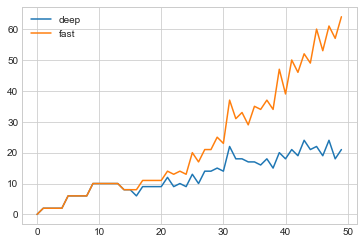

In [19]:
def queries_at_depth(conn, depth):
    d = pd.read_sql_query(con = conn,
                           sql = 'select count(*) as count from PATH where DEPTH = ?;',
                           params = [depth])
    return d['count'][0]

xv = range(50)
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
ax.plot(xv, [queries_at_depth(deepconn,v) for v in xv], label='deep')
ax.plot(xv, [queries_at_depth(fastconn,v) for v in xv], label='fast')
plt.legend()

TODO: 
 - histogram branches per internal method loc
 - repeat above experiment with ap
 - explain canoncacalize(s)
 - how often could "app only call graph" improve call site precision?

In [38]:
conn = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/paths_antennapod.db")
conn_ap_slow = create_connection("/Users/shawnmeier/Desktop/bounder_debug_data/paths.db")

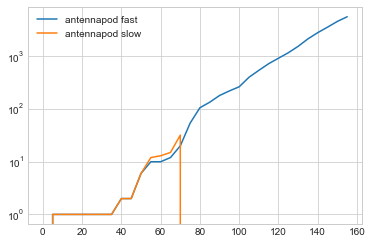

In [45]:
xv = [v* 5 for v in range(32)]
fig = plt.figure()
ax = plt.axes()

x = np.linspace(0, 10, 1000)
yv = [queries_at_depth(conn,v) for v in xv]
yvs = [queries_at_depth(conn_ap_slow,v) for v in xv]
ax.plot(xv, yv, label='antennapod fast')
ax.plot(xv,yvs,label='antennapod slow')
plt.yscale("log")
plt.legend()

In [35]:
def selectNonSkippedMethods(conn):
    #TGT - node that is later in control flow
    #SRC - node earlier in control flow
    tgtIsIntRet = 'and TGT.NODE_LOC like "%InternalMethodReturn%" '
    srcIsAppLoc = 'and SRC.NODE_LOC like ' + \
        '"%colorado.plv.bounder.ir.AppLoc%"'
    qry = 'SELECT count(SRC.NODE_ID) as count, TGT.NODE_LOC as method '+\
        'from PATH TGT, PATH SRC ' + \
        ' where SRC.NODE_ID <> TGT.NODE_ID and SRC.PRED = TGT.NODE_ID '+ \
        tgtIsIntRet + \
        srcIsAppLoc + \
        ' group by TGT.NODE_LOC order by count(SRC.NODE_ID) desc;'
#         (' limit 10;' % limit if limit is not None else '')
    edges = pd.read_sql_query(con = conn,
                sql = qry)
    return edges

def count_internal_call_edges(conn, clazz, name):
    edges = get_call_edges(conn, clazz, name)
    contains = edges['TGT_CLASS'].apply(lambda x: 'de.danoeh' in x)
    edges = edges[contains]
    
    return len(edges.index)
nonSkipped = selectNonSkippedMethods(conn)
mn = lambda x: parse_loc(x)[2]
mc = lambda x: parse_loc(x)[1]
nonSkipped['method_name'] = nonSkipped['method'].apply(mn)
nonSkipped['method_class'] = nonSkipped['method'].apply(mc)
nonSkipped['call_count'] = nonSkipped.apply(
        lambda row: count_internal_call_edges(conn,row['method_class'],row['method_name']),
        axis = 1
    )
nonSkipped = nonSkipped.drop(columns=['method'])
nonSkipped['comb'] = nonSkipped['count']*nonSkipped['call_count']
#'count','call_count' excluded
nonSkipped = nonSkipped[['count','comb','method_name','method_class']]
nonSkipped = nonSkipped.sort_values(by='comb',ascending=False)
display_no_limit(nonSkipped)
# plt.barh("method_name",'count',data=nonSkipped)

,count,comb,method_name,method_class
1,1046,5230,"de.danoeh.antennapod.core.feed.FeedItem getFeedItem(long,de.danoeh.antennapod.core.storage.PodDBAdapter)",de.danoeh.antennapod.core.storage.DBReader
9,536,4288,de.danoeh.antennapod.core.feed.FeedMedia getFeedMedia(long),de.danoeh.antennapod.core.storage.DBReader
4,679,2716,de.danoeh.antennapod.core.feed.FeedItem getFeedItem(long),de.danoeh.antennapod.core.storage.DBReader
5,639,2556,int getPosition(),de.danoeh.antennapod.core.service.playback.LocalPSMP
3,723,2169,int getPosition(),de.danoeh.antennapod.core.util.playback.PlaybackController
15,285,1710,boolean loadMediaInfo(),de.danoeh.antennapod.activity.MediaplayerActivity
6,618,1236,de.danoeh.antennapod.core.util.playback.Playable createInstanceFromPreferences(android.content.Context),de.danoeh.antennapod.core.util.playback.Playable$PlayableUtils
8,562,1124,de.danoeh.antennapod.core.util.playback.Playable createExternalMediaInstance(android.content.SharedPreferences),de.danoeh.antennapod.core.util.playback.Playable$PlayableUtils
13,345,1035,int getDuration(),de.danoeh.antennapod.core.util.playback.PlaybackController
18,210,840,void onPositionObserverUpdate(),de.danoeh.antennapod.activity.MediaplayerActivity


<BarContainer object of 20 artists>

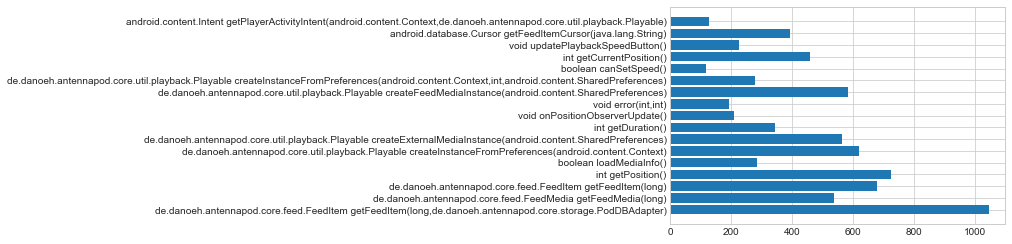

In [36]:
plt.barh('method_name','count', data=nonSkipped.head(20))

In [21]:
bodies = get_method(conn,"%activity.MediaplayerActivity%","%void onPositionObserverUpdate%")['BODY']
for b in bodies:
    print(shorten_body(highlight_text(b,["arg$1","subscription","controller"])))

    void onPositionObserverUpdate()
    {
        _ap.activity.MediaplayerActivity r0;
        _apcu.PlaybackController r1;
        android.widget.TextView r2;
        int $i0, $i1, $i2;
        _jl.StringBuilder $r3;
        _jl.String $r4;
        boolean $z0;

        r0 := @this: _ap.activity.MediaplayerActivity;

        r1 = r0.<_ap.activity.MediaplayerActivity: _apcu.PlaybackController  controller >;

        if r1 == null goto label6;

        r2 = r0.<_ap.activity.MediaplayerActivity: android.widget.TextView txtvPosition>;

        if r2 == null goto label6;

        r2 = r0.<_ap.activity.MediaplayerActivity: android.widget.TextView txtvLength>;

        if r2 != null goto label1;

        return;

     label1:
        r1 = r0.<_ap.activity.MediaplayerActivity: _apcu.PlaybackController  controller >;

        $i0 = virtualinvoke r1.<_apcu.PlaybackController: int getPosition()>();

        r1 = r0.<_ap.activity.MediaplayerActivity: _apcu.PlaybackController  controller >;

     

In [ ]:
bodies = get_method(conn,"%activity.MediaplayerActivity%","%void onPositionObserverUpdate%")['BODY']
for b in bodies:
    print(shorten_body(highlight_text(b,["arg$1","subscription","controller"])))

In [ ]:
# Highlight methods containing
highlight_methods_containing(conn,"playback.PlaybackController","arg$1")



In [ ]:
display_call_edges(conn, "de.danoeh.antennapod.core.util.playback.PlaybackController","void checkMediaInfoLoaded()")


In [ ]:
bodies = get_method(conn,"%util.playback.PlaybackController%","%void checkMediaInfoLoaded()%")['BODY']
for b in bodies:
    print(shorten_body(highlight_text(b,["arg$1","subscription","controller"])))

Experiment: how much fanout results from call graph imprecision?

In [ ]:
## Most commony visited internal methods
callLocs = pd.read_sql_query(con = conn,
        sql = 'select count(NODE_ID),NODE_LOC from PATH ' +
                 'where NODE_LOC like "%InternalMethod%" ' +
                 'group by NODE_LOC order by count(NODE_ID) desc;')
locOp = lambda x:shorten_body(str(parse_loc(x)))
typeOp = lambda x:parse_loc(x)[0]
classOp = lambda x:parse_loc(x)[1]
callLocs['NODE_LOC'] = callLocs['NODE_LOC'].apply(typeOp)
callLocs['Class'] = callLocs['NODE_LOC'].apply(classOp)
display_no_limit(callLocs)

In [ ]:
## Visited internal methods that aren't skipped

In [ ]:
## Do we hit any recursive methods?
## - no, keep this around for now

## Directly recursive methods TODO: doesn't include mutually recursive
dRec = pd.read_sql_query(con = conn,
                        sql = 'select * from CALL_EDGES where SRC_NAME = TGT_NAME and SRC_CLASS == TGT_CLASS')
recMethods = []
for ind,row in dRec.iterrows():
    recMethods.append(("%" + row['SRC_NAME'] + "%",
                       "%" + row['SRC_CLASS'] + "%"))

outR = None
count = 0
for rm in recMethods:
    count = count+1
    print(count)
    cdf = pd.read_sql_query(con=conn,
                    sql="SELECT distinct NODE_LOC from PATH where NODE_LOC like ? and NODE_LOC like ?;",
                    params = [rm[0],rm[1]])
    print("rows: %i" % len(cdf.index))
    if outR == None:
        outR == cdf
    else:
        outR.append(cdf)

In [22]:
def selectNonSkippedMethods(conn):
    #TGT - node that is later in control flow
    #SRC - node earlier in control flow
    tgtIsIntRet = 'and TGT.NODE_LOC like "%InternalMethodReturn%" '
    srcIsAppLoc = 'and SRC.NODE_LOC like ' + \
        '"%colorado.plv.bounder.ir.AppLoc%"'
    qry = 'SELECT count(SRC.NODE_ID) as count, TGT.NODE_LOC as method '+\
        'from PATH TGT, PATH SRC ' + \
        ' where SRC.NODE_ID <> TGT.NODE_ID and SRC.PRED = TGT.NODE_ID '+ \
        tgtIsIntRet + \
        srcIsAppLoc + \
        ' group by TGT.NODE_LOC order by count(SRC.NODE_ID) desc;'
#         (' limit 10;' % limit if limit is not None else '')
    edges = pd.read_sql_query(con = conn,
                sql = qry)
    return edges

def count_internal_call_edges(conn, clazz, name):
    edges = get_call_edges(conn, clazz, name)
    contains = edges['TGT_CLASS'].apply(lambda x: 'de.danoeh' in x)
    edges = edges[contains]
    
    return len(edges.index)
nonSkipped = selectNonSkippedMethods(conn)
mn = lambda x: parse_loc(x)[2]
mc = lambda x: parse_loc(x)[1]
nonSkipped['method_name'] = nonSkipped['method'].apply(mn)
nonSkipped['method_class'] = nonSkipped['method'].apply(mc)
nonSkipped['call_count'] = nonSkipped.apply(
        lambda row: count_internal_call_edges(conn,row['method_class'],row['method_name']),
        axis = 1
    )
nonSkipped = nonSkipped.drop(columns=['method'])
nonSkipped['comb'] = nonSkipped['count']*nonSkipped['call_count']
#'count','call_count' excluded
nonSkipped = nonSkipped[['comb','method_name','method_class']]
nonSkipped = nonSkipped.sort_values(by='comb',ascending=False)
display_no_limit(nonSkipped)

KeyboardInterrupt: 

In [37]:
get_call_edges(conn, "de.danoeh.antennapod.core.storage.DBReader", "de.danoeh.antennapod.core.feed.FeedItem getFeedItem(long,de.danoeh.antennapod.core.storage.PodDBAdapter)")

,TGT_NAME,TGT_CLASS
0,void close(),android.database.MergeCursor
1,java.lang.Object get(int),java.util.concurrent.CopyOnWriteArrayList
2,android.database.Cursor getFeedItemCursor(java...,de.danoeh.antennapod.core.storage.PodDBAdapter
3,java.lang.Object get(int),java.util.Vector
4,java.lang.String toString(),java.lang.StringBuilder
5,java.lang.Object get(int),kotlin.collections.ArraysKt___ArraysKt$asList$3
6,java.lang.StringBuilder append(java.lang.String),java.lang.StringBuilder
7,java.lang.Object get(int),kotlin.collections.ArraysKt___ArraysKt$asList$1
8,java.lang.Object get(int),kotlin.collections.EmptyList
9,void close(),android.database.AbstractCursor


In [ ]:
display_no_limit()